# 巡回セールスマン問題

巡回セールスマン問題とは、複数の都市を訪問し、すべての都市を一度ずつ巡った後、出発地点に戻る最短経路を求める問題です。CP-SATの`add_circuit()`と`minimize()`を併用することで、この問題を解くことができます。本章では、巡回セールスマン問題の概要と、CP-SATを用いた解法について説明します。

巡回セールスマン問題（TSP）の難点は、以下のような点にあります。  

* 計算量の爆発（組み合わせ爆発
   - TSPはNP困難（NP-hard）に分類される問題であり、都市の数 \( N \) が増えると、考えられる経路の数は \( (N-1)!/2 \) という指数関数的な増加を示します。  
   - 例えば、10都市では約18万通り、20都市では約1.2兆通りもの経路が存在し、単純な総当たりでは解くことが困難になります。  

* 最適解を求めるのが難しい
   - 近似アルゴリズム（貪欲法、局所探索、遺伝的アルゴリズムなど）を使えば高速に解が得られますが、必ずしも最適解とは限りません。  
   - 厳密解を求めるには、整数線形計画法（MILP）、分枝限定法、動的計画法（Held-Karpアルゴリズム）などの高度な手法が必要ですが、都市数が増えると計算コストが急激に増加します。  


In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import spatial
from matplotlib.collections import LineCollection
from ortools.sat.python import cp_model

## テストデータ  

次のコードでは、ランダムに100点の座標を生成し、それらの点間の距離行列を計算します。CP-SATは整数のみを扱うため、距離を1000倍して整数に変換します。  

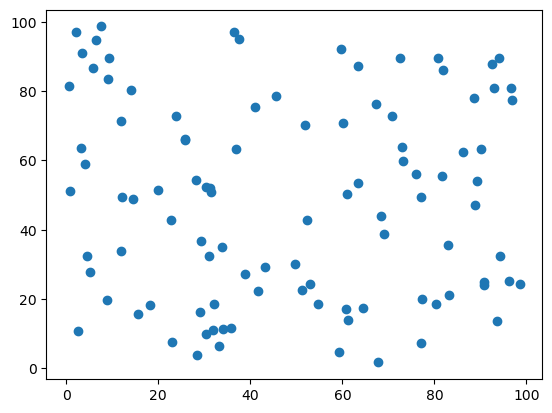

In [4]:
n = 100
np.random.seed(42)
points = np.random.uniform(0, 100, size=(n, 2))
dist_matrix = (spatial.distance.squareform(spatial.distance.pdist(points)) * 1000).astype(np.int32)
fig, ax = plt.subplots()
ax.scatter(points[:, 0], points[:, 1]);

## TSP問題を解くコード

次の `ObjectiveTracker` は、`CpSolverSolutionCallback` を継承したコールバッククラスで、最適化の途中経過（目的関数の履歴）を記録するためのものです。`self.history` に `self.objective_value`（現在の目的関数値）を追加することで、解がどのように改善されていくかを追跡できます。

In [10]:
class ObjectiveTracker(cp_model.CpSolverSolutionCallback):
    def __init__(self):
        super().__init__()
        self.history = []

    def on_solution_callback(self):
        self.history.append(self.objective_value)

次の `solve_points_tsp()` 関数は、実際に TSP 問題を解くものです。引数は以下のとおりです。  

- `points`：都市（座標）のリスト  
- `dist_matrix`：都市間の距離行列  
- `log_history`：`True` の場合、探索履歴を記録  
- `max_time`：ソルバーの最大実行時間（秒）

TSP 問題を解くには、まず `dist_matrix` を `(i, j)` のキーに変換し、辞書 `edges` に格納します。`i != j` の条件により、同じ都市への自己ループは除外されます。これにより、都市間のエッジの重み（距離）を記録できます。  

次に、各エッジ `(i, j)` に対して、対応する `0` または `1` のブール変数を作成します。解として `True` が選択された場合、そのエッジが巡回路に含まれることを意味します。  

`add_circuit()` を使用すると、1 つの閉じた巡回路になるように制約が追加され、すべての都市を 1 回だけ訪問し、最終的に出発点に戻るようになります。`LinearExpr.weighted_sum()` を用いて、選択されたエッジの合計距離を計算し、`model.minimize(length)` によって、この合計距離が最小となるよう最適化を行います。

In [ ]:
def solve_points_tsp(points, dist_matrix, log_history=False, max_time=10):
    edges = {}
    for (i, j), d in np.ndenumerate(dist_matrix):
        if i != j:
            edges[i, j] = int(d)

    model = cp_model.CpModel()
    variables = {key:model.new_bool_var(f'{i}') for i, key in enumerate(edges)}
    model.add_circuit([(s, e, v) for (s, e), v in variables.items()])
    length = cp_model.LinearExpr.weighted_sum(list(variables.values()), list(edges.values()))
    model.minimize(length)
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = max_time
    if log_history:
        callback = ObjectiveTracker()
        status = solver.solve(model, callback)
        print(callback.history)
    else:
        status = solver.solve(model)
    
    selected_edges = points[np.array([key for key, v in variables.items() if solver.value(v)])]
    return selected_edges

次に、100 点のランダムな座標について TSP を解いてみます。

[4269157.0, 1128682.0, 1077553.0, 1070650.0, 1068858.0, 1064624.0, 1046599.0, 778747.0, 761230.0]


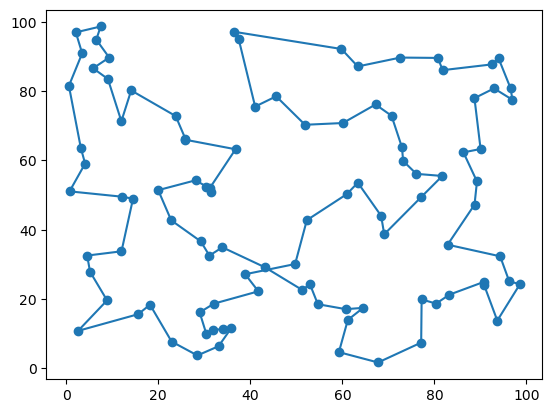

In [11]:
selected_edges = solve_points_tsp(points, dist_matrix, log_history=True)
fig, ax = plt.subplots()
ax.scatter(points[:, 0], points[:, 1])
ax.add_collection(LineCollection(selected_edges));

## 線分の TSP 問題  

作成したブール変数に追加の制約を加えることで、さまざまな特殊な TSP 問題を解くことができます。たとえば、次の問題では50 本の線分を巡回する最適なルートを求めます。次のコードでは、各線分の始点 (`start_points`) と終点 (`end_points`) をランダムに生成し、TSP の対象とします。

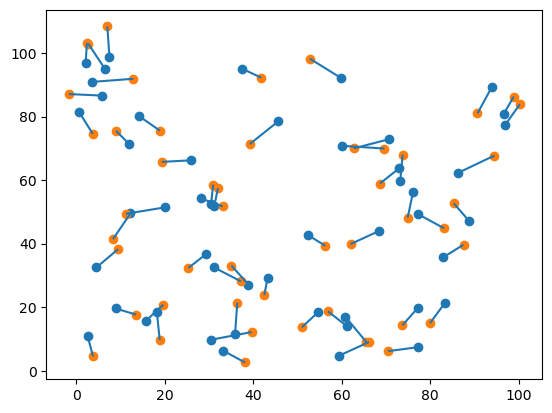

In [13]:
n = 50
np.random.seed(42)
start_points = np.random.uniform(0, 100, size=(n, 2))
length = np.random.uniform(5, 10, size=n)
angle = np.random.uniform(0, 2 * np.pi, size=n)
end_points = start_points + np.c_[length * np.cos(angle), length * np.sin(angle)]
segments = np.column_stack([start_points, end_points])
points = segments.reshape(-1, 2)
fig, ax = plt.subplots()
ax.scatter(start_points[:, 0], start_points[:, 1])
ax.scatter(end_points[:, 0], end_points[:, 1])
ax.add_collection(LineCollection(segments.reshape(-1, 2, 2)))

次のコードでは、同じ線分の端点間の距離を 0 に設定し、`solve_points_tsp()` を使用して解いてみましたが、解はすべての線分（赤色）を通っていません。その理由は、同じ線分の端点間のコストは 0 になりますが、それでも巡回路全体の長さを最小化しようとするため、すべての線分を経由するとは限りません。

[4720978.0, 947648.0, 930508.0, 845542.0, 828402.0, 809087.0, 482796.0]


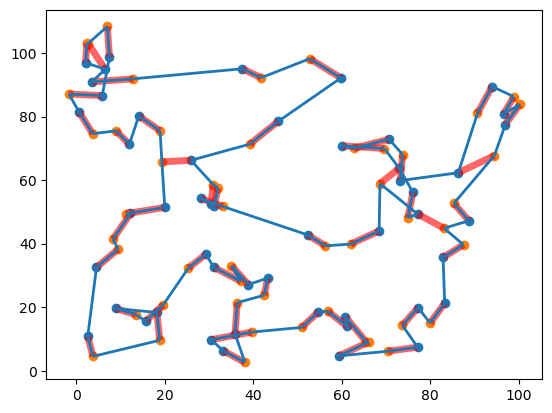

In [14]:
dist_matrix = (spatial.distance.squareform(spatial.distance.pdist(segments.reshape(-1, 2))) * 1000).astype(np.int32)
start_index = np.arange(0, n*2, 2)
end_index = start_index + 1
dist_matrix[start_index, end_index] = 0
dist_matrix[end_index, start_index] = 0

selected_edges = solve_points_tsp(points, dist_matrix, log_history=True)
fig, ax = plt.subplots()
ax.scatter(start_points[:, 0], start_points[:, 1])
ax.scatter(end_points[:, 0], end_points[:, 1])
ax.add_collection(LineCollection(segments.reshape(-1, 2, 2), linewidth=5, color='red', alpha=0.6))
ax.add_collection(LineCollection(selected_edges, linewidth=2))

次のコードでは、同じ線分の端点 `s` と `e` に対して、辺 `(s, e)` と `(e, s)` に対応するブール変数の一方が必ず `True` になるように制約を追加し、すべての線分を通る制約を加えています。
これで、`solve_segments_tsp()` 関数がすべての線分を通る巡回ルートを最適化します。

In [17]:
def solve_segments_tsp(points, dist_matrix, log_history=False, max_time=10):
    edges = {}
    for (i, j), d in np.ndenumerate(dist_matrix):
        if i != j:
            edges[i, j] = int(d)

    n = dist_matrix.shape[0]
    start_index = np.arange(0, n, 2)
    end_index = start_index + 1

    model = cp_model.CpModel()
    variables = {key:model.new_bool_var(f'{i}') for i, key in enumerate(edges)}
    model.add_circuit([(s, e, v) for (s, e), v in variables.items()])
    
    for s, e in zip(start_index, end_index):
        model.add_exactly_one([variables[s, e], variables[e, s]])
    
    length = cp_model.LinearExpr.weighted_sum(list(variables.values()), list(edges.values()))
    model.minimize(length)
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = max_time
    if log_history:
        callback = ObjectiveTracker()
        status = solver.solve(model, callback)
        print(callback.history)
    else:
        status = solver.solve(model)
    
    selected_edges = points[np.array([key for key, v in variables.items() if solver.value(v)])]
    return selected_edges

次に、線分の TSP 問題を解いてみます。結果からわかるように、ルートはすべての線分を通っています。このコードでは、`solve_segments_tsp()` 関数で求めた最適な巡回ルートをプロットしています。赤色で示された線分が元々の線分で、選ばれた巡回ルート（最適な経路）が別の色で表示されます。

[873781.0, 733917.0, 720673.0, 700814.0, 623658.0, 544530.0, 543938.0, 527675.0, 527083.0, 482358.0, 480641.0]


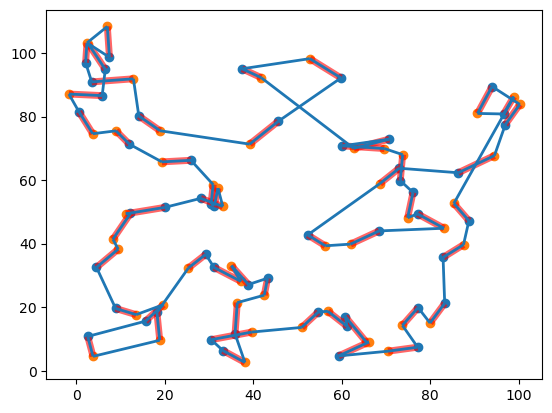

In [19]:
selected_edges = solve_segments_tsp(points, dist_matrix, log_history=True)
fig, ax = plt.subplots()
ax.scatter(start_points[:, 0], start_points[:, 1])
ax.scatter(end_points[:, 0], end_points[:, 1])
ax.add_collection(LineCollection(segments.reshape(-1, 2, 2), linewidth=5, color='red', alpha=0.6))
ax.add_collection(LineCollection(selected_edges, linewidth=2))